### Training a corpus-wide RMN with tfidf embeddings

In [1]:
import os
import sys
import pandas as pd

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")

In [3]:
from document import load_documents
from constant import DOC_PRAYER_PATH, MIN_SESSION, MAX_SESSION, DOC_ALL_PATH
from subject import subject_keywords

sessions = list(range(MIN_SESSION, MAX_SESSION+1))

In [4]:
from helper import *
from rmn import *
from rmn_data_generator import RMN_DataGenerator
from rmn_analyzer import RMN_Analyzer

In [5]:
# load embedding tools
prayer_tools_path = "/home/rocassius/gen-data/tools/prayer_tools"

global_embedding_matrix = load_pickled_object(os.path.join(prayer_tools_path, "embedding_matrix_wg"))
global_tokenizer_dict = load_pickled_object(os.path.join(prayer_tools_path, "tokenizer_dict_wg"))

In [6]:
docs_df = load_documents([111], DOC_PRAYER_PATH)

In [7]:
data_df = docs_df

In [8]:
docs_df.shape

(92754, 10)

In [9]:
local_models_path = "/home/rocassius/gen-data/models"

In [10]:
rmn = RigidRMN()
rmn.load_rmn("SuaveRanger", local_models_path)
rmn.infer_embedding_matrix = global_embedding_matrix
rmn.infer_tokenizer_dict = global_tokenizer_dict

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
#====================#
#=*= RMN Analyzer =*=#
#====================#

# Class for analyzing an RMN

import numpy as np
import pandas as pd
from analysis import *

# variable constants
SUB = 'subject'
SPEAK = 'speakerid'
PARTY = 'party'
SESS = 'session'
# party constants
R = 'R'
D = 'D'
# metric constants
JS = 'js'
HH = 'hh'
EN = 'entr'
N_REC = 'n_records'
N_NAN = 'n_nan_preds'
TP = 'topic_use'


class RMN_Analyzer(object):
    """Class for Analyzing an RMN with respect to a dataset
    """
    
    def __init__(self, rmn, df):
        """
        Args:
        - rmn: (RMN) the RMN to be used for analysis
        - df : (DataFrame) the dataframe to analyze
        """
        
        'Initialization'
        self.rmn = rmn
        self.df = df.reset_index(drop=True)
        self.topic_preds = None
        self.y_preds = None
        
        self.topic_nns = None
        self.topic_coherence = None
        
        
    @property
    def index(self):
        return self.df.index
        
    
    def predict_topics(self, use_generator=False, k_primary_topics=5):
        """Computes the topic predictions for all observations
        """
        # predict topics
        self.topic_preds = self.rmn.predict_topics(self.df, use_generator)
        # dataframe of first k topics for each record
        primary_topics = self.primary_topics({}, k_primary_topics)
        primary_df = pd.DataFrame(primary_topics, columns=range(1, k_primary_topics+1))
        # update analyzer dataframe
        self.df = self.df.join(primary_df)
        
    
    def predict_y(self, use_generator=True):
        """Computes the sentence vector predictions for all observations
        """
        self.y_preds = self.rmn.predict_y(self.df, use_generator)
        
        
    def sample_indices(self, indices, n):
        """Returns a SRR of the indices provided
        """
        return np.random.choice(indices, n, replace=True)

    
    def bool_subset(self, col, value):
        """
        Returns a boolean vector for each observation in the
        dataframe indicating whether it meets the col == value condition
        """
        assert col in self.df.columns
        return self.df[col] == value
    
    
    def bool_index(self, conditions):
        """
        Returns a boolean vector for each observation in the
        dataframe indicating whether it meets all conditions
        
        Args:
        - conditions: (dict) dictionary of conditions
        
        Returns: 
        - pandas series of booleans indicating where all 
          of the conditions hold
        """
        # initialize bool index
        bool_index = (pd.Series(True)
                      .repeat(self.index.shape[0])
                      .reset_index(drop=True))
        
        for col, val in conditions.items():
            bool_index = bool_index & self.bool_subset(col, val)
            
        return bool_index
    
    
    def cond_index(self, conditions):
        """Returns indices of records meeting the conditions
        """
        return self.index[self.bool_index(conditions)]
    
    
    def n_records(self, conditions={}):
        """Returns the number of records meetings the conditions
        """
        return len(self.cond_index(conditions))
    
    
    def n_nan_preds(self, conditions={}):
        """Returns the number of records which have nan predictions
        """
        cond_index = self.cond_index(conditions)
        return np.isnan(self.topic_preds[cond_index].sum(axis=-1)).sum().item()
    
    
    def compute_JS(self, index_A, index_B, base=2):
        """
        Computes the mean pair-wise JS divergence and associated CI
        between indices in index_A and indices in index_B
        """
        p_A = self.topic_preds[index_A]
        p_B = self.topic_preds[index_B]
        js_list = [jensenshannon(p, q, base) for p, q in zip(p_A, p_B)]
        
        return mean_CI(js_list)
        
        
    def compute_HH(self, index):
        """
        Computes the mean HH index and associated CI between
        indices in index_A and indices in index_B
        """
        p = self.topic_preds[index]
        hh_list = [hh_index(q) for q in p]
        
        return mean_CI(hh_list)
    
    
    def topic_use_RD_js(self, conditions={}):
        """Returns the JS divergence of the R and D topic use distributions
        """
        R_topic_use = self.topic_use({**conditions, **{PARTY: R}})
        D_topic_use = self.topic_use({**conditions, **{PARTY: D}})
        
        return jensenshannon(R_topic_use, D_topic_use)
    
    
    def topic_use_hh(self, conditions={}):
        """Returns the HH-index of the RD topic use distributions
        """
        return hh_index(self.topic_use(conditions))
    
    
    def inter_party_js(self, conditions, n):
        """
        Returns the estimated inter party JS divergence and a CI.
        
        Computes the inter party JS divergence between 
        Republicans and Democrats on a given subject
        
        Args:
        - subject: (str) subject to examine
        - n      : (int) sample size
        
        Returns: a numpy array of length 3, where
        - 0 is the mean divergence point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # find R and D indicies on the subject
        index_R = self.cond_index({**conditions, **{PARTY: R}})
        index_D = self.cond_index({**conditions, **{PARTY: D}})
        
        # return None if indices are insufficient
        if len(index_R)==0 or len(index_D)==0:
            return None
        
        # sample 
        samp_index_R = self.sample_indices(index_R, n)
        samp_index_D = self.sample_indices(index_D, n)
    
        return self.compute_JS(samp_index_R, samp_index_D)
    
    
    def group_js(self, conditions, n):
        """
        Returns the estimated mean JS divergence and a CI
        
        Estimates the average JS divergence between any two documents of
        a group defined by the conditions. A document by speaker _i_ is 
        never compared to another document by speaker _i_.
        
        
        Args:
        - conditions: (dict) dictionary of conditions
        - n         : (int) sample size
        
        Returns: a numpy array of length 3, where index...
        - 0 is the mean divergence point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # find indicies of party on the subject
        cond_index = self.cond_index(conditions)
        
        # Return none if there are fewer than 2 speakers
        if self.df.loc[cond_index][SPEAK].nunique() < 2:
            return None
        
        # Sample index pairs
        index_AB = []
        while len(index_AB) < n:
            a_b = self.sample_indices(cond_index, n=2)
            # include samples whose speakers are different
            if self.df.loc[a_b][SPEAK].nunique() == 2:
                index_AB.append(a_b)
        
        index_AB = np.asarray(index_AB)
        assert index_AB.shape == (n, 2)
        
        # get indices for each group
        index_A, index_B = index_AB[:,0], index_AB[:,1]
        
        return self.compute_JS(index_A, index_B)
    
    
    def group_hh(self, conditions={}, n=None):
        """
        Returns the estimated mean HH index and a CI
        
        Estimates the average Herfindahl–Hirschman Index 
        of all records meetings the conditons.
        
        Args:
        - subject: (str) subject to examine
        - party  : (str) party of interest
        - n      : (int) sample size
        
        Returns: a numpy array of length 3, where index...
        - 0 is the mean index point estimate:
        - 1 is the lower bound of a 95% CI
        - 2 is the upper bound of a 95% CI
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        # indicies meeting the conditions
        cond_index = self.cond_index(conditions)
        
        # return None if indices are insufficient
        if len(cond_index)==0:
            return None
        
        if n is None:
            return self.compute_HH(cond_index)
        else:
            samp_index = self.sample_indices(cond_index, n)
            return self.compute_HH(samp_index)
        
        
    def analyze_subset(self, conditions, n):
        """
        Returns a dictionary of analysis metrics for the subset 
        of records defined by the conditions.
        
        Note: It is recommended conditions be on subject
        
        Args:
        - conditions: (dict) dictionary of conditions
        - n         : (int) sample size for estimation of metrics
        
        for the entire dataset and for each subject the following are computed:
        - n_records, n_records_R
        - n_records_D
        - js
        - js_R
        - js_D
        - js_RD
        - hh
        - hh_R
        - hh_D
        
        Returns: a dictionary of metrics
        """
        # R and D added conditions
        conditions_R = {**conditions, **{PARTY: R}}
        conditions_D = {**conditions, **{PARTY: D}}
        
        # annotation tags
        _R = '_' + R
        _D = '_' + D
        _RD = _R + D
        _TP = '_' + TP
        
        metrics = {
            # n records in data
            N_REC:    self.n_records(conditions),
            N_REC+_R: self.n_records(conditions_R),
            N_REC+_D: self.n_records(conditions_D),
            N_NAN+_R: self.n_nan_preds(conditions_R),
            N_NAN+_D: self.n_nan_preds(conditions_D),
            # JS divergence data
            JS:     self.group_js(conditions, n),
            JS+_R:  self.group_js(conditions_R, n),
            JS+_D:  self.group_js(conditions_D, n),
            JS+_RD: self.inter_party_js(conditions, n),
            # HH index data
            HH:    self.group_hh(conditions, n),
            HH+_R: self.group_hh(conditions_R, n),
            HH+_D: self.group_hh(conditions_D, n),
            # Topic Use Metrics
            HH+_TP:    self.topic_use_hh(conditions),
            HH+_TP+_R: self.topic_use_hh(conditions_R),
            HH+_TP+_D: self.topic_use_hh(conditions_D),
            JS+_TP:    self.topic_use_RD_js(conditions),
        }
        
        return metrics
    
        
    def analyze(self, subjects, n):
        """
        Returns a dictionary of analysis metrics at the subject level
        and at the session level (assuming self.df is the data of a
        single session).
        
        Args:
        - subjects: (array-like) list of subjects
        - n       : (int) sample size for estimation of metrics
        
        Returns: a dictionary of metrics
        """
        # analyze entire session dataset
        dataset_metrics = self.analyze_subset(conditions={}, n=n)
        
        # analyze by subject
        subject_metrics = {}
        for s in subjects:
            subject_metrics[s] = self.analyze_subset({SUB: s}, n)
        
        metrics = {'dataset' : dataset_metrics, 
                   'subjects': subject_metrics}
        
        return metrics
    
    
    def shannon_entropy(self, conditions={}):
        """Returns the Shannon Entropy of topic predictions meeting conditions
        """
        # ensure that the topic predictions exist
        if self.topic_preds is None:
            self.predict_topics()
        
        return shannon_entropy(self.topic_preds[self.cond_index(conditions)])
    
    
    def mean_entropy(self, conditions={}):
        """Returns the mean entropy of topic predictions meeting condiditons
        """
        return np.nanmean(self.shannon_entropy(conditions))
        
    
    def first_topic_counts(self, conditions={}):
        """
        Returns a leaderboard of topics and how many times they 
        are the primary topic associated with a document.
        """
        if self.topic_preds is None:
            self.predict_topics()
           
        cond_index = self.cond_index(conditions)
        topic_counts = pd.Series(np.argmax(self.topic_preds[cond_index], axis=-1)).value_counts()
        
        return topic_counts
    
    
    def topic_use(self, conditions={}):
        """
        Returns a leaderboard of topics based on the percentage of 
        total weight given to them in all of the documents
        """
        cond_index = self.cond_index(conditions)
        topic_sums = pd.Series(np.nansum(self.topic_preds[cond_index], axis=0))
        topic_use = topic_sums.sort_values(ascending=False) / topic_sums.sum()
        
        return topic_use
    
    
    def primary_topics(self, conditions={}, k=5):
        """Returns top k most prominent topics for documents
        """
        cond_index = self.cond_index(conditions)
        primary_topics = np.flip(np.argsort(self.topic_preds[cond_index]), axis=-1)[:,:k]
        
        return primary_topics
    
    
    def find_topic_nns(self):
        """Finds the nearest neighbors of the rmn's topics
        """
        self.topic_nns = np.array(self.rmn.inspect_topics())
      
    
    def find_topic_coherence(self, k=5):
        """Updates the topic coherence scores of the 
        """
        W = self.rmn.infer_embedding_matrix
        word_index = self.rmn.infer_tokenizer_dict['word_index']
        coherence_scores = [word_coherence(np.array(t)[:5,0], word_index, W) 
                            for t in self.topic_nns]
        
        self.topic_coherence = pd.Series(coherence_scores).sort_values(ascending=False)
    
    @property
    def topic_nn_sim(self):
        return pd.Series(self.topic_nns[:,0,1]).sort_values(ascending=False)
    
    
    def sample_records(self, conditions, n=10):
    
        samp_index = self.cond_index(conditions)
        if len(samp_index) > n:
            samp_index = np.random.choice(samp_index, n)
            
        self.show_records(samp_index)
    
    
    def show_records(self, index):
        
        for rec in analyzer.df.loc[index].itertuples():
            print(30*'=')
            print('SPEAKER:', rec.firstname, rec.lastname)
            print('PARTY:  ', rec.party)
            print('SESSION:', rec.session)
            print('SUBJECT:', rec.subject)
            print('\n', rec.document, '\n')
            print('PRIMARY TOPICS:', 
                  rec._11, rec._12, rec._13, rec._14, rec._15, '\n')
        
        

In [12]:
analyzer = RMN_Analyzer(rmn, data_df)

In [13]:
analyzer.predict_topics()

In [116]:
# nns = analyzer.topic_nns
analyzer.topic_nns = nns

In [14]:
analyzer.find_topic_nns()

/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: divide by zero encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))
/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: invalid value encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))



Topic 0
['necessary', 'adequate', 'appropriate', 'useful', 'properly', 'efficiently', 'utilize', 'tasks', 'providing', 'provide']

Topic 1
['day', 'end', 'next', 'strike', 'ends', 'week', 'planned', 'off', 'on', 'call']

Topic 2
['territories', 'lands', 'granted', 'abolished', 'legally', 'privileges', 'permitted', 'governed', 'territory', 'permit']

Topic 3
['father', 'friend', 'mother', 'wife', 'brother', 'son', 'daughter', 'husband', 'uncle', 'cousin']

Topic 4
['companies', 'company', 'business', 'software', 'manufacturers', 'industry', 'businesses', 'electronics', 'technology', 'firms']

Topic 5
['drink', 'amount', 'liquid', 'amounts', 'soda', 'concoction', 'excess', 'ingredients', 'ingredient', 'essence']

Topic 6
['countries', 'asia', 'nations', 'europe', 'africa', 'trade', 'china', 'asian', 'cooperation', 'european']

Topic 7
['religion', 'religious', 'freedom', 'beliefs', 'equality', 'ideals', 'ideology', 'belief', 'faith', 'democracy']

Topic 8
['e', 'page', 'k', 'w', 'text',

In [15]:
analyzer.df

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session,1,2,3,4,5
0,111116451,KOHL,HERBERT,S,WI,M,D,responsibility to protect those who cannot pro...,abortion,111,7,30,23,49,19
1,111117170,TOWNS,EDOLPHUS,H,NY,M,D,obama said i thought that was pretty tough and...,abortion,111,37,15,30,19,32
2,111115330,BEAN,MELISSA,H,IL,F,D,change the laws of this country of seeking to ...,abortion,111,34,7,21,17,16
3,111121930,FOSTER,BILL,H,IL,M,D,good character restraint respect for law and r...,abortion,111,25,21,31,47,7
4,111117650,HOLT,RUSH,H,NJ,M,D,this bill contains outofcontrol spending it co...,abortion,111,43,4,19,41,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92749,111120531,MIKULSKI,BARBARA,S,MD,F,D,of a more accurate food facility registry impr...,trade,111,19,22,44,42,35
92750,111120170,LATTA,ROBERT,H,OH,M,R,their lives to save others that day these meda...,trade,111,27,32,9,49,20
92751,111116441,HUTCHISON,KAY,S,TX,F,R,investment this year the development assistanc...,trade,111,43,4,16,35,22
92752,111120860,POLIS,JARED,H,CO,M,D,economytoo much in the last decade of folks pa...,trade,111,30,42,4,44,32


In [47]:
analyzer.df.columns

Index(['speakerid',  'lastname', 'firstname',   'chamber',     'state',
          'gender',     'party',  'document',   'subject',   'session',
                 1,           2,           3,           4,           5],
      dtype='object')

In [48]:
analyzer.primary_topics({1:3})

array([[ 3, 19, 49, 30, 15],
       [ 3, 49, 15, 19, 37],
       [ 3, 46,  7, 37, 15],
       ...,
       [ 3, 15, 32, 27, 30],
       [ 3, 27, 30, 41, 17],
       [ 3, 30, 41, 49, 37]])

In [18]:
analyzer.df

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session,1,2,3,4,5
0,111116451,KOHL,HERBERT,S,WI,M,D,responsibility to protect those who cannot pro...,abortion,111,7,30,23,49,19
1,111117170,TOWNS,EDOLPHUS,H,NY,M,D,obama said i thought that was pretty tough and...,abortion,111,37,15,30,19,32
2,111115330,BEAN,MELISSA,H,IL,F,D,change the laws of this country of seeking to ...,abortion,111,34,7,21,17,16
3,111121930,FOSTER,BILL,H,IL,M,D,good character restraint respect for law and r...,abortion,111,25,21,31,47,7
4,111117650,HOLT,RUSH,H,NJ,M,D,this bill contains outofcontrol spending it co...,abortion,111,43,4,19,41,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92749,111120531,MIKULSKI,BARBARA,S,MD,F,D,of a more accurate food facility registry impr...,trade,111,19,22,44,42,35
92750,111120170,LATTA,ROBERT,H,OH,M,R,their lives to save others that day these meda...,trade,111,27,32,9,49,20
92751,111116441,HUTCHISON,KAY,S,TX,F,R,investment this year the development assistanc...,trade,111,43,4,16,35,22
92752,111120860,POLIS,JARED,H,CO,M,D,economytoo much in the last decade of folks pa...,trade,111,30,42,4,44,32


In [19]:
t = 3

In [20]:
analyzer.n_records({1: t})

2363

In [21]:
analyzer.n_records({1: t, 2:49, 'party': 'D'})

151

In [22]:
analyzer.group_js({1: t, 'party': 'R'}, n=1000)

{'mean': 0.40234835430284815,
 'lower': 0.3907380108645118,
 'upper': 0.4139586977411845}

In [192]:
analyzer.group_js({1:t, 'party':'D'}, n=1000)

{'mean': 0.401486127255301,
 'lower': 0.38995162326401134,
 'upper': 0.4130206312465906}

In [208]:
analyzer.group_js({1: t, 2:49}, n=10000)

{'mean': 0.29860196084287766,
 'lower': 0.2951070819590711,
 'upper': 0.302096839726684}

In [210]:
analyzer.inter_party_js({1: t, 2:49}, n=10000)

{'mean': 0.2983802398607582,
 'lower': 0.2949612511842003,
 'upper': 0.30179922853731594}

Analysis of particular members

In [23]:
analyzer.df[]

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session,1,2,3,4,5
4663,111121460,SPEIER,JACKIE,H,CA,F,D,is to force reductions in carbon emissions thr...,budget,111,22,42,48,4,45
65174,111116481,LUGAR,RICHARD,S,IN,M,R,military involved in peacekeeping efforts thro...,health,111,19,43,16,35,49
14661,111114561,VOINOVICH,GEORGE,S,OH,M,R,scout and played trumpet in the cyfair high sc...,defense,111,3,41,27,11,15
27452,111118351,INHOFE,JAMES,S,OK,M,R,holiday that gives families making a year a ...,economy,111,16,30,32,19,20
8784,111117790,RAHALL,NICK,H,WV,M,D,president i compliment my dear friend and dist...,defense,111,31,21,39,3,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38747,111116471,LIEBERMAN,JOSEPH,S,CT,M,I,of desktop software blackberry web design onli...,education,111,4,43,41,27,33
88263,111118321,DURBIN,RICHARD,S,IL,M,D,president i rise to about the tax relief unemp...,tax,111,42,24,48,13,30
10220,111114101,DORGAN,BYRON,S,ND,M,D,lexington on july scott reed graduated with ...,defense,111,41,27,11,43,31
41930,111121791,WYDEN,RON,S,OR,M,D,paying that back when people me the question w...,education,111,37,30,15,3,17


In [118]:
analyzer.df.subject.value_counts()

defense         17537
foreign         16928
economy         10586
labor            9593
education        9586
tax              6859
health           6802
budget           4325
minorities       2762
trade            2267
drug_alcohol     1656
immigration      1265
guns             1132
women            1049
abortion          407
Name: subject, dtype: int64

In [24]:
analyzer.sample_records(conditions={'firstname': 'NICK', 'lastname':'RAHALL', 'subject':'tax'}, n=20)

SPEAKER: NICK RAHALL
PARTY:   D
SESSION: 111
SUBJECT: tax

 legislation in the past and we hope that our colleagues see this bill for what it is a reasonable solution to an unintentional inequity in our tax code this legislation would allow living artists to deduct the fairmarket value of their art work when they contribute their work to museums 

PRIMARY TOPICS: 43 10 4 33 34 

SPEAKER: NICK RAHALL
PARTY:   D
SESSION: 111
SUBJECT: tax

 nothing the government has done to date is working instead the previous and the current administrations have been throwing billions in good taxpayer dollars into bad failing banks why hasnt pouring more money into the system worked because policymakers are only treating the symptoms 

PRIMARY TOPICS: 19 16 42 32 30 

SPEAKER: NICK RAHALL
PARTY:   D
SESSION: 111
SUBJECT: tax

 they cannot believe that the republicans could be so cruel and insensitive to their needs they have worked all their lives they have paid their taxes they have contributed to unem

In [26]:
analyzer.topic_nns[[24, 26, 10, 48, 42]]

array([[['exacerbated', '0.694'],
        ['unnecessarily', '0.678'],
        ['inevitable', '0.667'],
        ['embarrassing', '0.657'],
        ['embarrassment', '0.656'],
        ['unfortunate', '0.654'],
        ['fear', '0.649'],
        ['unnecessary', '0.647'],
        ['vicious', '0.647'],
        ['intolerable', '0.646']],

       [['loans', '0.815'],
        ['assets', '0.812'],
        ['funds', '0.81'],
        ['investments', '0.795'],
        ['debt', '0.787'],
        ['mortgage', '0.785'],
        ['bonds', '0.782'],
        ['credit', '0.782'],
        ['securities', '0.77'],
        ['asset', '0.765']],

       [['importance', '0.764'],
        ['challenges', '0.747'],
        ['understand', '0.728'],
        ['focus', '0.725'],
        ['situation', '0.724'],
        ['perspective', '0.721'],
        ['fundamental', '0.714'],
        ['understanding', '0.712'],
        ['progress', '0.712'],
        ['important', '0.712']],

       [['budget', '0.849'],
        ['spe

In [104]:
analyzer.n_records({'subject':'abortion'})

116

In [172]:
analyzer.n_records({'firstname': 'VIRGINIA','lastname':'FOXX', 'subject':'tax'})

56

In [185]:
analyzer.n_records({'firstname': 'NICK', 'lastname':'RAHALL', 'subject':'tax'})

30

In [ ]:
analyzer.

In [193]:
t1 = analyzer.topic_use({'firstname': 'VIRGINIA','lastname':'FOXX', 'subject':'tax'})[0:10].round(4)
# t1 = analyzer.topic_use({'lastname':'CHAMBLISS', 'subject':'tax'})[0:10].round(4)
#t1 = analyzer.topic_use({'lastname':'ROS-LEHTINEN', 'subject':'tax'})[0:10].round(4)

t1.round(2)

26    0.12
48    0.10
42    0.09
16    0.07
37    0.06
43    0.06
23    0.05
4     0.05
22    0.05
17    0.05
dtype: float32

In [196]:
analyzer.topic_nns[t1.index]

array([[['loans', '0.815'],
        ['assets', '0.812'],
        ['funds', '0.81'],
        ['investments', '0.795'],
        ['debt', '0.787'],
        ['mortgage', '0.785'],
        ['bonds', '0.782'],
        ['credit', '0.782'],
        ['securities', '0.77'],
        ['asset', '0.765']],

       [['budget', '0.849'],
        ['spending', '0.834'],
        ['cuts', '0.763'],
        ['deficit', '0.752'],
        ['tax', '0.75'],
        ['fiscal', '0.737'],
        ['taxes', '0.733'],
        ['expenditures', '0.724'],
        ['deficits', '0.719'],
        ['stimulus', '0.717']],

       [['inflation', '0.851'],
        ['growth', '0.846'],
        ['rise', '0.845'],
        ['decline', '0.84'],
        ['rising', '0.83'],
        ['increases', '0.822'],
        ['slowing', '0.821'],
        ['rates', '0.82'],
        ['rate', '0.803'],
        ['slowdown', '0.803']],

       [['care', '0.861'],
        ['medicaid', '0.861'],
        ['medicare', '0.849'],
        ['benefits', '0.

In [192]:
t2 = analyzer.topic_use({'firstname': 'NICK', 'lastname':'RAHALL', 'subject':'tax'})[0:10].round(4)
# t1 = analyzer.topic_use({'lastname':'CHAMBLISS', 'subject':'tax'})[0:10].round(4)
#t1 = analyzer.topic_use({'lastname':'ROS-LEHTINEN', 'subject':'tax'})[0:10].round(4)

t2.round(2)

37    0.15
16    0.12
4     0.08
48    0.07
30    0.06
17    0.06
24    0.05
32    0.05
22    0.04
26    0.04
dtype: float32

In [197]:
analyzer.topic_nns[t2.index]

array([[['know', '0.904'],
        ['maybe', '0.903'],
        ['everybody', '0.901'],
        ['really', '0.901'],
        ['think', '0.901'],
        ['else', '0.89'],
        ["'m", '0.886'],
        ['nobody', '0.884'],
        ['anybody', '0.881'],
        ['thing', '0.88']],

       [['care', '0.861'],
        ['medicaid', '0.861'],
        ['medicare', '0.849'],
        ['benefits', '0.804'],
        ['health', '0.791'],
        ['insurance', '0.777'],
        ['welfare', '0.755'],
        ['pensions', '0.752'],
        ['pension', '0.744'],
        ['beneficiaries', '0.737']],

       [['companies', '0.822'],
        ['company', '0.787'],
        ['business', '0.784'],
        ['software', '0.779'],
        ['manufacturers', '0.766'],
        ['industry', '0.762'],
        ['businesses', '0.755'],
        ['electronics', '0.751'],
        ['technology', '0.741'],
        ['firms', '0.737']],

       [['budget', '0.849'],
        ['spending', '0.834'],
        ['cuts', '0.763'],

In [188]:
import matplotlib.pyplot as plt

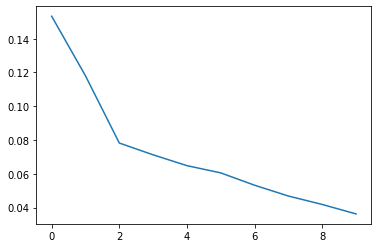

In [190]:
plt.plot(range(len(t1)), t1)

In [187]:
analyzer.topic_nns[t1.index]

array([[['know', '0.904'],
        ['maybe', '0.903'],
        ['everybody', '0.901'],
        ['really', '0.901'],
        ['think', '0.901'],
        ['else', '0.89'],
        ["'m", '0.886'],
        ['nobody', '0.884'],
        ['anybody', '0.881'],
        ['thing', '0.88']],

       [['care', '0.861'],
        ['medicaid', '0.861'],
        ['medicare', '0.849'],
        ['benefits', '0.804'],
        ['health', '0.791'],
        ['insurance', '0.777'],
        ['welfare', '0.755'],
        ['pensions', '0.752'],
        ['pension', '0.744'],
        ['beneficiaries', '0.737']],

       [['companies', '0.822'],
        ['company', '0.787'],
        ['business', '0.784'],
        ['software', '0.779'],
        ['manufacturers', '0.766'],
        ['industry', '0.762'],
        ['businesses', '0.755'],
        ['electronics', '0.751'],
        ['technology', '0.741'],
        ['firms', '0.737']],

       [['budget', '0.849'],
        ['spending', '0.834'],
        ['cuts', '0.763'],

In [178]:
analyzer.n_records({'firstname': 'JERRY','lastname':'LEWIS', 'subject':'tax'})

26

In [179]:
#analyzer.df.loc[analyzer.cond_index({'lastname':'LEWIS', 'subject':'tax'})]

In [182]:
# t2 = analyzer.topic_use({'lastname':'AKIN', 'subject':'tax'})[0:10].round(4)
# t2 = analyzer.topic_use({'lastname':'BEAN', 'subject':'tax'})[0:10].round(4)
t2 = analyzer.topic_use({'firstname': 'JERRY','lastname':'LEWIS', 'subject':'tax'})[0:10].round(4)


t2

16    0.1601
30    0.0883
48    0.0835
37    0.0814
22    0.0606
26    0.0508
47    0.0414
25    0.0405
23    0.0382
17    0.0368
dtype: float32

In [183]:
analyzer.topic_nns[t2.index]

array([[['care', '0.861'],
        ['medicaid', '0.861'],
        ['medicare', '0.849'],
        ['benefits', '0.804'],
        ['health', '0.791'],
        ['insurance', '0.777'],
        ['welfare', '0.755'],
        ['pensions', '0.752'],
        ['pension', '0.744'],
        ['beneficiaries', '0.737']],

       [['families', '0.812'],
        ['parents', '0.773'],
        ['children', '0.77'],
        ['youngsters', '0.766'],
        ['kids', '0.748'],
        ['mothers', '0.736'],
        ['living', '0.73'],
        ['people', '0.726'],
        ['elderly', '0.72'],
        ['teenagers', '0.715']],

       [['budget', '0.849'],
        ['spending', '0.834'],
        ['cuts', '0.763'],
        ['deficit', '0.752'],
        ['tax', '0.75'],
        ['fiscal', '0.737'],
        ['taxes', '0.733'],
        ['expenditures', '0.724'],
        ['deficits', '0.719'],
        ['stimulus', '0.717']],

       [['know', '0.904'],
        ['maybe', '0.903'],
        ['everybody', '0.901'],
    

In [ ]:
df = data